In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import List
from PIL import Image
from sklearn.manifold import TSNE
np.random.seed(42)
%matplotlib inline

## 1. Distance between PDFs

In [2]:
## Helper functions for the question

def normalized_hist_of_img(img: np.ndarray):
    """
    Given an image, this function computes the normalized histogram of the image.
    A histogram means the count of each pixel value in the image.
    Normalized histogram is the histogram divided by the total number of pixels in the image.
    """
    pixels_list = img.flatten().tolist()

    # Count the number of pixels for each pixel value
    hist = [pixels_list.count(i) for i in range(256)]
    num_pixels = len(pixels_list)

    # Normalize the histogram
    norm_hist = [h / num_pixels for h in hist]
    return norm_hist

def entropy_discrete_rv(pmf: List[float], zero_threshold = 1e-15):
    """
    Computes the entropy of a discrete random variable whose pmf is given.
    """
    entropy = 0.0
    for p in pmf:
        # Ignore zero probability events by using a zero threshold
        if abs(p) > zero_threshold:
            entropy -= p * np.log2(p)
    return entropy

def kl_divergence(pmf_p: List[float], pmf_q: List[float], zero_threshold = 1e-15):
    """
    Returns the KL divergence between the distributions p and q i.e. D(p||q)
    """
    assert len(pmf_p) == len(pmf_q), "Both distributions should have the same length."

    divergence = 0.0

    for i in range(len(pmf_p)):
        # Ignore the zero probability events
        if pmf_q[i] <= zero_threshold or pmf_p[i] <= zero_threshold:
            continue

        divergence += pmf_p[i] * np.log2(pmf_p[i] / pmf_q[i])

    return divergence

Load the images

In [3]:
# Path of the images. You can change this to the path of your images.
LEFT_IMG_PATH = '../HW1/left.png'
RIGHT_IMG_PATH = '../HW1/right.png'

# Load the images
left_img = np.asarray(Image.open(LEFT_IMG_PATH))
right_img = np.asarray(Image.open(RIGHT_IMG_PATH))

# Compute the normalized histograms of the images
left_norm_hist = normalized_hist_of_img(left_img)
right_norm_hist = normalized_hist_of_img(right_img)

### (a) Cross Entropy

In [4]:
def cross_entropy(pmf_p: List[float], pmf_q: List[float], zero_threshold = 1e-15):
    """
    Returns the cross entropy between the distributions p and q i.e. H(p, q)
    """
    assert len(pmf_p) == len(pmf_q), "Both distributions should have the same length."

    # H(p)
    h_p = entropy_discrete_rv(pmf_p, zero_threshold = zero_threshold)

    # D(p||q)
    d_pq = kl_divergence(pmf_p, pmf_q, zero_threshold = zero_threshold)

    # H(p, q) = H(p) + D(p||q)
    ce = h_p + d_pq
    return ce

#### (i)

In [5]:
# Verify the function using the stereo image normalized histogram pair
ce_left_right = cross_entropy(left_norm_hist, right_norm_hist)
print(f"Cross entropy between the left and right stereo images: {ce_left_right}")

Cross entropy between the left and right stereo images: 7.273398119987328


#### (ii)
$p \sim Bern(r)$, $r = const.$<br>
$q \sim Bern(s)$

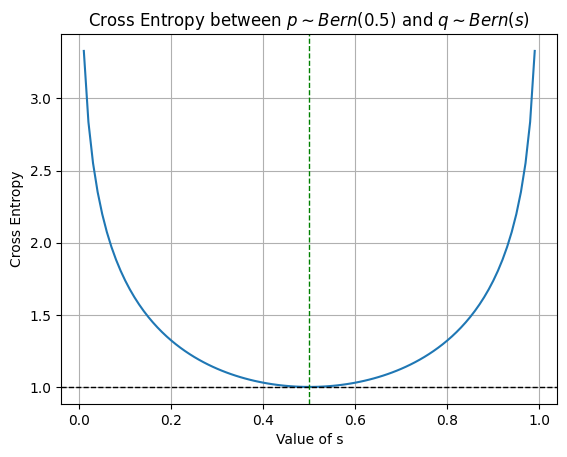

In [6]:
# Distribution p
r = 0.5
pmf_p = [1-r, r]

# Value of s from [0.01 to 0.99]
s_values = [0.01 * i for i in range(1, 100)]

ce_values = []

for s in s_values:
    # Distribution q
    pmf_q = [1-s, s]

    # Compute the cross entropy between p and q
    ce = cross_entropy(pmf_p, pmf_q)
    ce_values.append(ce)

plt.plot(s_values, ce_values)

# Plot y = 1
plt.axhline(1, color='black', lw=1, linestyle='--')

# Plot x = 0.5
plt.axvline(0.5, color='green', lw=1, linestyle='--')

plt.xlabel('Value of s')
plt.ylabel('Cross Entropy')
plt.title(f'Cross Entropy between $p \\sim Bern({r})$ and $q \\sim Bern(s)$')
plt.grid()
plt.show()

It can be seen from the plot that minimizing $H(p, q)$ give us $s = r$ i.e., matched PMFs.

### (b) Jensen Shannon (JS) Divergence

In [7]:
def js_divergence(pmf_p: List[float], pmf_q: List[float], zero_threshold = 1e-15):
    """
    Returns the Jensen-Shannon divergence between the distributions p and q i.e., J(p, q)
    """
    assert len(pmf_p) == len(pmf_q), "Both distributions should have the same length."

    # m = (p + q) / 2
    pmf_m = [(p+q)/2 for p, q in zip(pmf_p, pmf_q)]

    # D(p||m)
    d_pm = kl_divergence(pmf_p, pmf_m, zero_threshold = zero_threshold)

    # D(q||m)
    d_qm = kl_divergence(pmf_q, pmf_m, zero_threshold = zero_threshold)

    # J(p, q) = (D(p||m) + D(q||m)) / 2
    j_pq = (d_pm + d_qm) / 2

    return j_pq

In [8]:
js_left_right = js_divergence(left_norm_hist, right_norm_hist)
js_right_left = js_divergence(right_norm_hist, left_norm_hist)

kl_left_right = kl_divergence(left_norm_hist, right_norm_hist)
kl_right_left = kl_divergence(right_norm_hist, left_norm_hist)

print(f"Proof that JS divergence is symmetric:")
print(f"JS(left, right): {js_left_right: .5f}")
print(f"JS(right, left): {js_right_left: .5f}")

print(f"\nProof that KL divergence is not symmetric:")
print(f"KL(left||right): {kl_left_right: .5f}")
print(f"KL(right||left): {kl_right_left: .5f}")

Proof that JS divergence is symmetric:
JS(left, right):  0.00367
JS(right, left):  0.00367

Proof that KL divergence is not symmetric:
KL(left||right):  0.01510
KL(right||left):  0.01441


### (c) Wasserstein Distance

In [9]:
def allclose(a: List[float], b: List[float], zero_threshold = 1e-15):
    """
    Returns True if all the elements of a and b are close to each other.
    """
    assert len(a) == len(b), "Both lists should have the same length."
    return all(abs(a[i] - b[i]) < zero_threshold for i in range(len(a)))

def check_joint_marginal(p_xy: List[List[float]],
                         r_x: List[float],
                         r_y: List[float],
                         zero_threshold = 1e-15):
    """
    The functions checks if p_xy belongs to Π(r,s) given r_x and r_y.
    """
    len_x = len(r_x)
    len_y = len(r_y)

    assert len(p_xy) == len_x, "The number of rows in p_xy should be equal to the length of r_x."
    assert all(len(row) == len_y for row in p_xy), "The number of columns in p_xy should be equal to the length of r_y."

    marginal_x = [sum(p_xy[i]) for i in range(len_x)]
    marginal_y = [sum([p_xy[i][j] for i in range(len_x)]) for j in range(len_y)]

    # Check if the marginal distributions are equal to r_x and r_y
    check_val = (allclose(marginal_x, r_x, zero_threshold = zero_threshold)) and \
                (allclose(marginal_y, r_y, zero_threshold = zero_threshold))
    
    return check_val

In [10]:
# Check with a positive example and a negative example

pos_example = {
    "p_xy": [[0.1, 0.2], [0.3, 0.4]],
    "r_x": [0.3, 0.7],
    "r_y": [0.4, 0.6]
}
pos_check = check_joint_marginal(**pos_example)
print(f"Positive example check: {pos_check}")

neg_example = {
    "p_xy": [[0.1, 0.15, 0.15], [0.3, 0.05, 0.05]],
    "r_x": [0.3, 0.7], # This is wrong
    "r_y": [0.4, 0.2, 0.2]
}
neg_check = check_joint_marginal(**neg_example)
print(f"Negative example check: {neg_check}")

Positive example check: True
Negative example check: False


## Q2: Visualizing Data Using t-SNE

### (a)
**i. What is crowding problem?**<br>
**Ans.** Crowding problem is the phenomenon where the pairwise distances between points in the high-dimensional space are not modeled accurately in the low-dimensional space. In high dimensions, distant points can be far-apart and SNE tries to model this by using a Gaussian distribution. However, in low dimensions, the Gaussian distribution assigns almost no probability to distant neighbors (and therefore, there is almost no effect of the distant points on loss function). Therefore, it results in crowding of the distant points at the same location in the low-dimensional space.
<br><br>
**ii. How does the choice of the Student t-distribution in the low dimensional embedding space
help address the crowding problem?**<br>
**Ans.** Since Student t-distribution has heavier tails than Gaussian distribution, it assigns more probability to the distant points in the low-dimensional space. So, it reflects in the loss function and optimizes the points in the low-dimensional space so that they remain far apart. This helps in addressing the crowding problem.
<br><br>
**iii. What other important changes have been made in t-SNE relative to SNE?**<br>
**Ans.** The important changes made in t-SNE relative to SNE are:
1. It uses symmetric SNE cost function i.e., instead of minimizing the sum of KL divergences between condition probabilities $p_{j|i}$ and $q_{j|i}$, it minimizes the sum of KL divergences between joint probabilities $p_{ij}$ and $q_{ij}$.
2. t-SNE's gradients are simpler and numerically stable, leading to faster convergence.
3. PCA is used to reduce the dimensionality of the data to 30 dimensions before applying t-SNE. This speeds up the computation of pairwise distances between the datapoints and suppresses some noise without severely distorting the interpoint distances.

### (b)

In [11]:
# Implementation of Algorithm 1 from t-SNE paper

## Helper functions
def norm(vec: List[float]):
    """
    Returns the norm of a vector
    """
    return math.sqrt(sum(v**2 for v in vec))

def generate_multivariate_gaussian(mean_vec: List[float],
                                   cov_scalar: float,
                                   num_samples: int = 10):
    """
    Generate samples from a multivariate Gaussian distribution with the given mean vector and covariance matrix = cov_scalar * I.
    """
    num_dim = len(mean_vec) # Number of dimensions
    std_dev = math.sqrt(cov_scalar) # Standard deviation

    samples = []

    for _ in range(num_samples):
        std_normal_samples = np.random.normal(0, 1, num_dim) # Mean = 0, Variance = 1
        # Scale the samples by the standard deviation and add the mean vector
        sample = [s * std_dev + m for s, m in zip(std_normal_samples, mean_vec)]
        samples.append(sample)
    
    return np.array(samples)

def low_dim_affinities(Y: np.ndarray):
    """
    Compute the low dimension affinities q_ij
    q_ij = (1+||y_i - y_j||^2)^-1 / Σ_(k!=l) (1+||y_k - y_l||^2)^-1
    """
    num_points, _ = Y.shape
    l2_distances = np.zeros((num_points, num_points))
    denominator = 0.0

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                l2_distances[i, j] = norm(Y[i] - Y[j])**2
                denominator += 1 / (1 + l2_distances[i, j])

    q = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                q[i, j] = (1 / (1 + l2_distances[i, j])) / denominator

    return q

def loss_function_tsne(P: np.ndarray, Q: np.ndarray, zero_threshold = 1e-15):
    """
    Returns the loss function C for t-SNE
    """
    num_points, _ = P.shape
    loss = 0.0

    for i in range(num_points):
        for j in range(num_points):
            if abs(P[i, j]) > zero_threshold and abs(Q[i, j]) > zero_threshold:
                loss += P[i, j] * np.log2(P[i, j] / Q[i, j])

    return loss

def gradient_matrix(P: np.ndarray, Q: np.ndarray, Y: np.ndarray):
    """
    Compute the gradient matrix dC/dY
    """
    num_points, low_dim = Y.shape
    grad_matrix = np.zeros((num_points, low_dim))

    for i in range(num_points):
        # Compute dC/dy_i
        temp_grad = np.zeros(low_dim)
        for j in range(num_points):
            if i != j:
                temp_grad += (P[i, j] - Q[i, j]) * (Y[i] - Y[j])/ (1 + norm(Y[i] - Y[j])**2)
            
        grad_matrix[i] = 4 * temp_grad
    
    return grad_matrix

def plot_2d_embeddings(Y: np.ndarray, title: str, ax):
    """
    Plots the 2D embeddings in the low dimensional space.
    """
    hf = Y.shape[0]//2
    # Plot the first half of the points in red
    ax.scatter(Y[:hf, 0], Y[:hf, 1], color='red', label='Cluster 1')
    # Plot the second half of the points in blue
    ax.scatter(Y[hf:, 0], Y[hf:, 1], color='blue', label='Cluster 2')
    ax.set_title(title)
    ax.legend()

In [12]:
## Parameters and data generation
high_dim = 10 # Dimension of high dimensional space
low_dim = 2 # Dimension of low dimensional space
num_points = 20 # Number of points
cov_scalar = 0.01 # Covariance scalar of the gaussian multivariate distributions
T = 50 # Number of iterations

sigma_i = math.sqrt(cov_scalar) # Standard deviation of the Gaussian distribution in the high dimensional space

# Generate the set X in the high dimensional space
mean_cluster_1 = [1.0]*high_dim # Mean of the first cluster
mean_cluster_2 = [10.0]*high_dim # Mean of the second cluster

cluster_1 = generate_multivariate_gaussian(mean_cluster_1, cov_scalar, num_samples=num_points//2)
rem_points = num_points - num_points//2 # Remaining points
cluster_2 = generate_multivariate_gaussian(mean_cluster_2, cov_scalar, num_samples=rem_points)

# Concatenate the points from cluster 1 and 2
X = np.concatenate([cluster_1, cluster_2], axis=0)

# Compute p_ij
p_conditional = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        if i == j:
            # p_(i | i) = 0
            p_conditional[i, j] = 0.0
        else:
            # p_(j | i)
            numerator = np.exp(-(norm(X[i] - X[j])**2) / (2 * (sigma_i**2)))
            denominator = sum(np.exp(-(norm(X[i] - X[k])**2) / (2 * (sigma_i**2)))
                              for k in range(num_points) if k != i)
            
            p_conditional[i, j] = numerator / denominator

# Joint probability matrix P
P = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        if i != j:
            # p_ij = (p_(j | i) + p_(i | j)) / (2 * num_points)
            P[i, j] = (p_conditional[i, j] + p_conditional[j, i]) / (2 * num_points)


# Initialize the low dimensional representation Y randomly by N(0, 1e-4)
Y = generate_multivariate_gaussian([0.0]*low_dim, cov_scalar = 1e-4, num_samples=num_points)

In [13]:
def t_SNE_custom(lr: float, alpha: float, ax, print_alpha: bool):
    """
    Performs the optimization using t-SNE algorithm using learning rate lr and momentum term alpha.
    """
    # Plot the initial embeddings
    kl_div_before = loss_function_tsne(P, low_dim_affinities(Y))
    plot_2d_embeddings(Y, title=f"Before optimization, D(P||Q)={kl_div_before: .3f}", ax = ax[0])

    Y_old_old = Y.copy() # Y_(t-2)
    Y_old = Y.copy() # Y_(t-1)
    Y_new = Y.copy() # Y_t

    # Optimization loop
    for _ in range(T):
        # Compute the low dimensional affinities Q
        Q = low_dim_affinities(Y_old)

        # Compute the gradient matrix
        grad = gradient_matrix(P, Q, Y_old)

        # Update Y_t
        Y_new = Y_old - lr * grad + alpha * (Y_old - Y_old_old)

        # Update the variables for the next iteration
        
        np.copyto(Y_old_old, Y_old) # Copy contents of Y_(t-1) to Y_(t-2)
        np.copyto(Y_old, Y_new) # Copy contents of Y_t to Y_(t-1)

    kl_divergence_after = loss_function_tsne(P, low_dim_affinities(Y_new))
    # Plot the final embeddings
    if print_alpha:
        plot_2d_embeddings(Y_new, title=f"$\\alpha={alpha}$, After optimization, D(P||Q)={kl_divergence_after: .3f}", ax = ax[1])
    else:
        plot_2d_embeddings(Y_new, title=f"$\\eta={lr}$, After optimization, D(P||Q)={kl_divergence_after: .3f}", ax = ax[1])

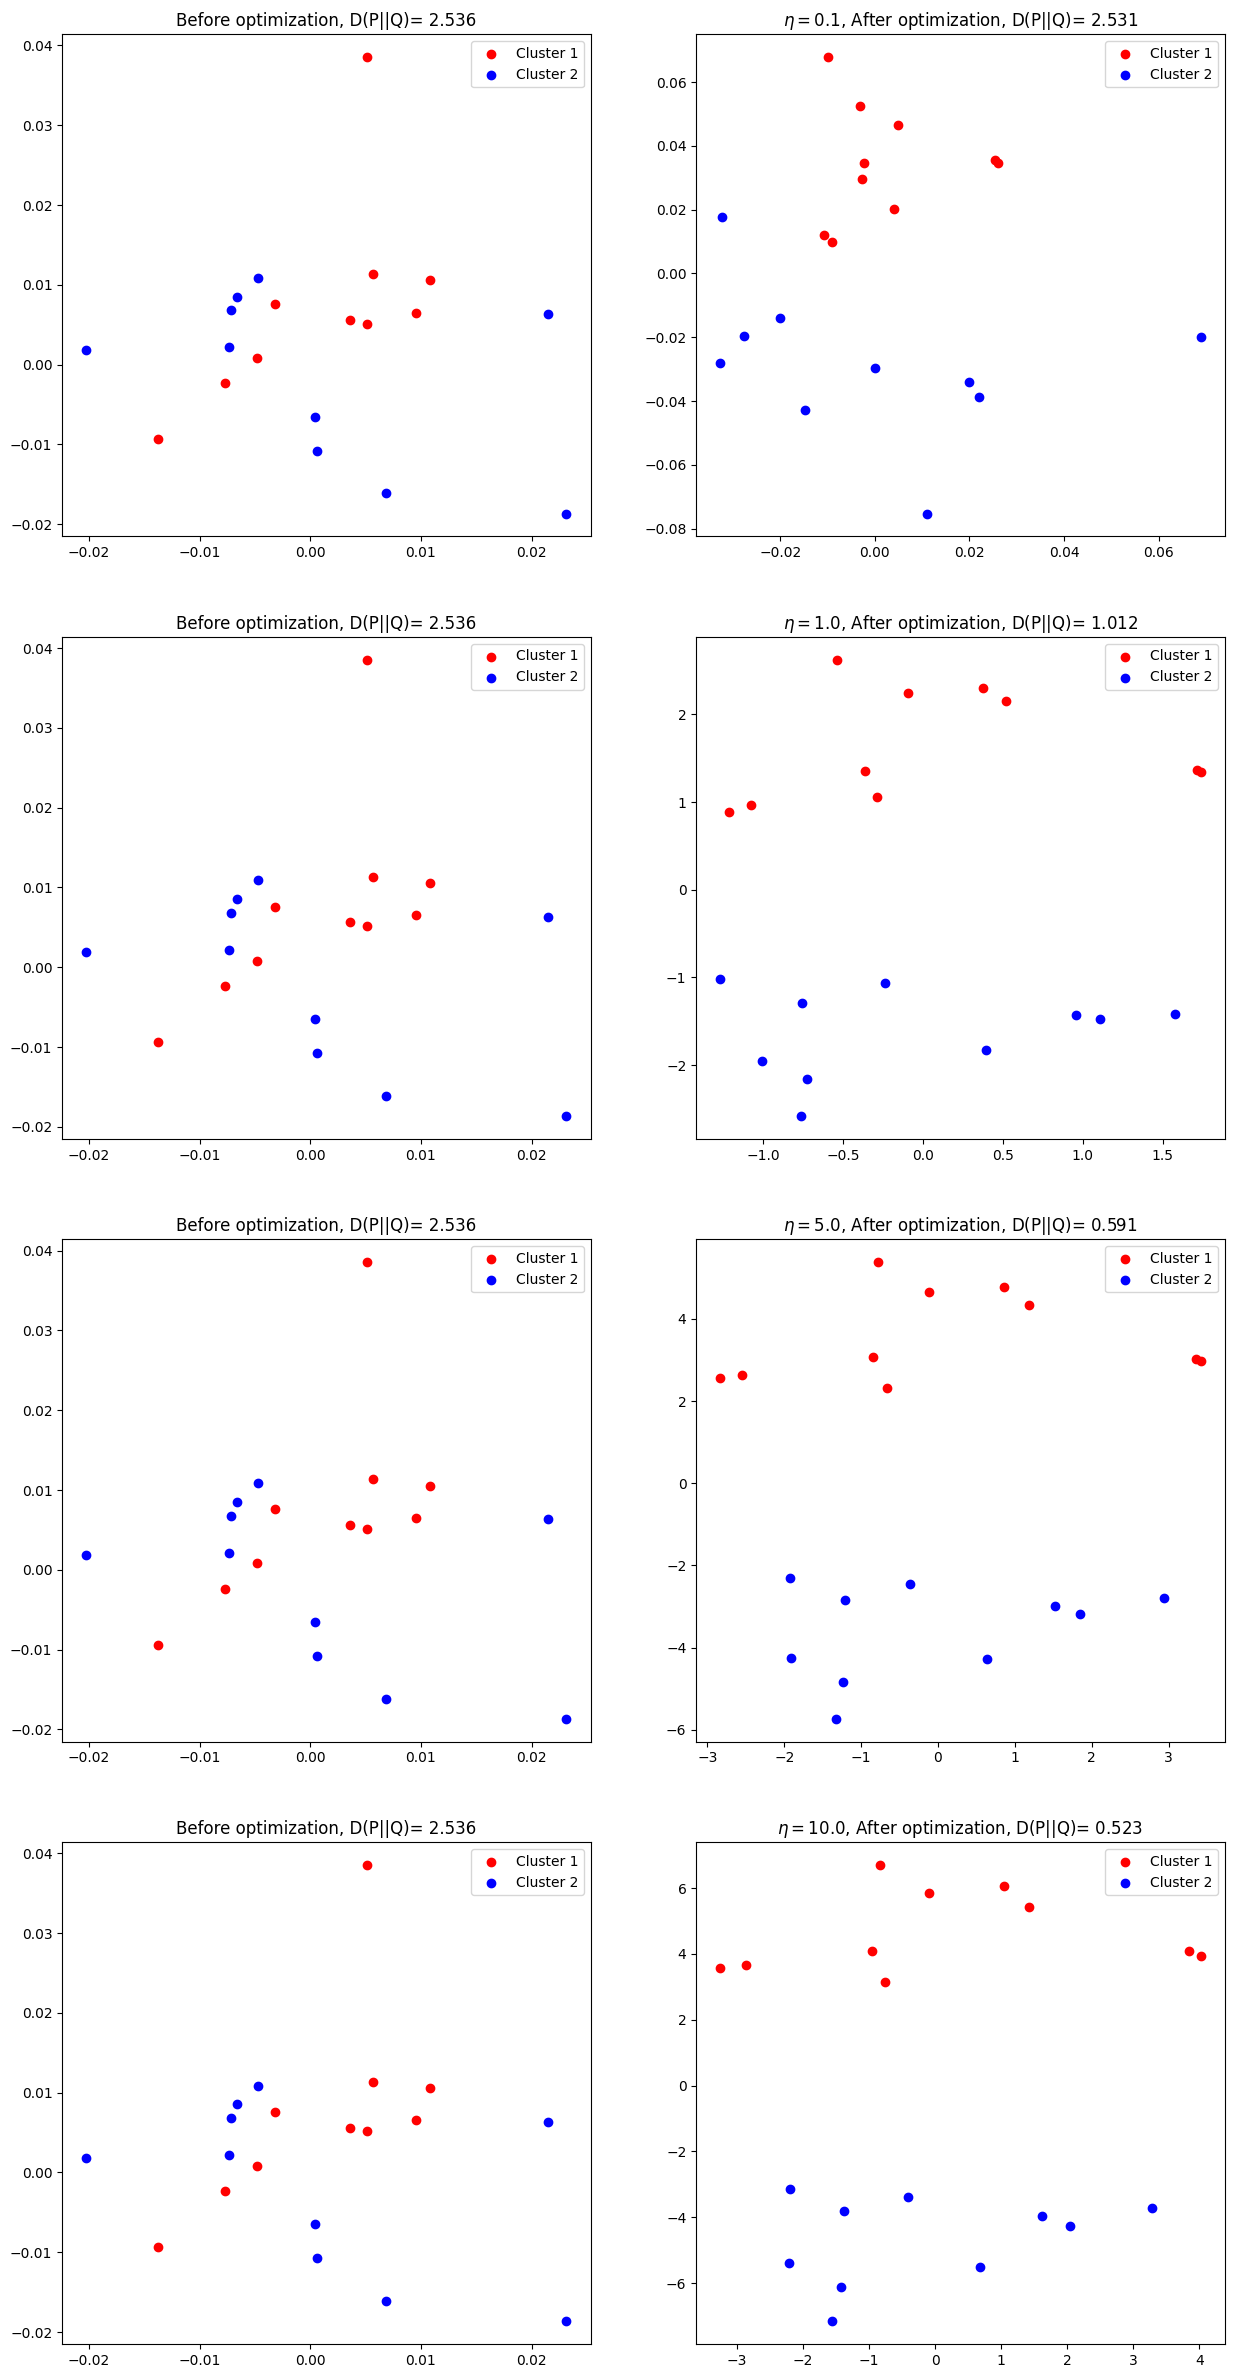

In [14]:
# Perform t-SNE optimization for values of learning rate
lrs = [0.1, 1.0, 5.0, 10.0] # Learning rate (paper uses 100)
alpha = 0.5 # Momentum term (paper uses 0.5 for the first 250 iterations and 0.8 for the remaining)
fig, ax = plt.subplots(len(lrs), 2, figsize=(15, 30))

# Plot the result of t-SNE for different values of learning rate
for i, lr in enumerate(lrs):
    t_SNE_custom(lr, alpha, ax[i], print_alpha=False)

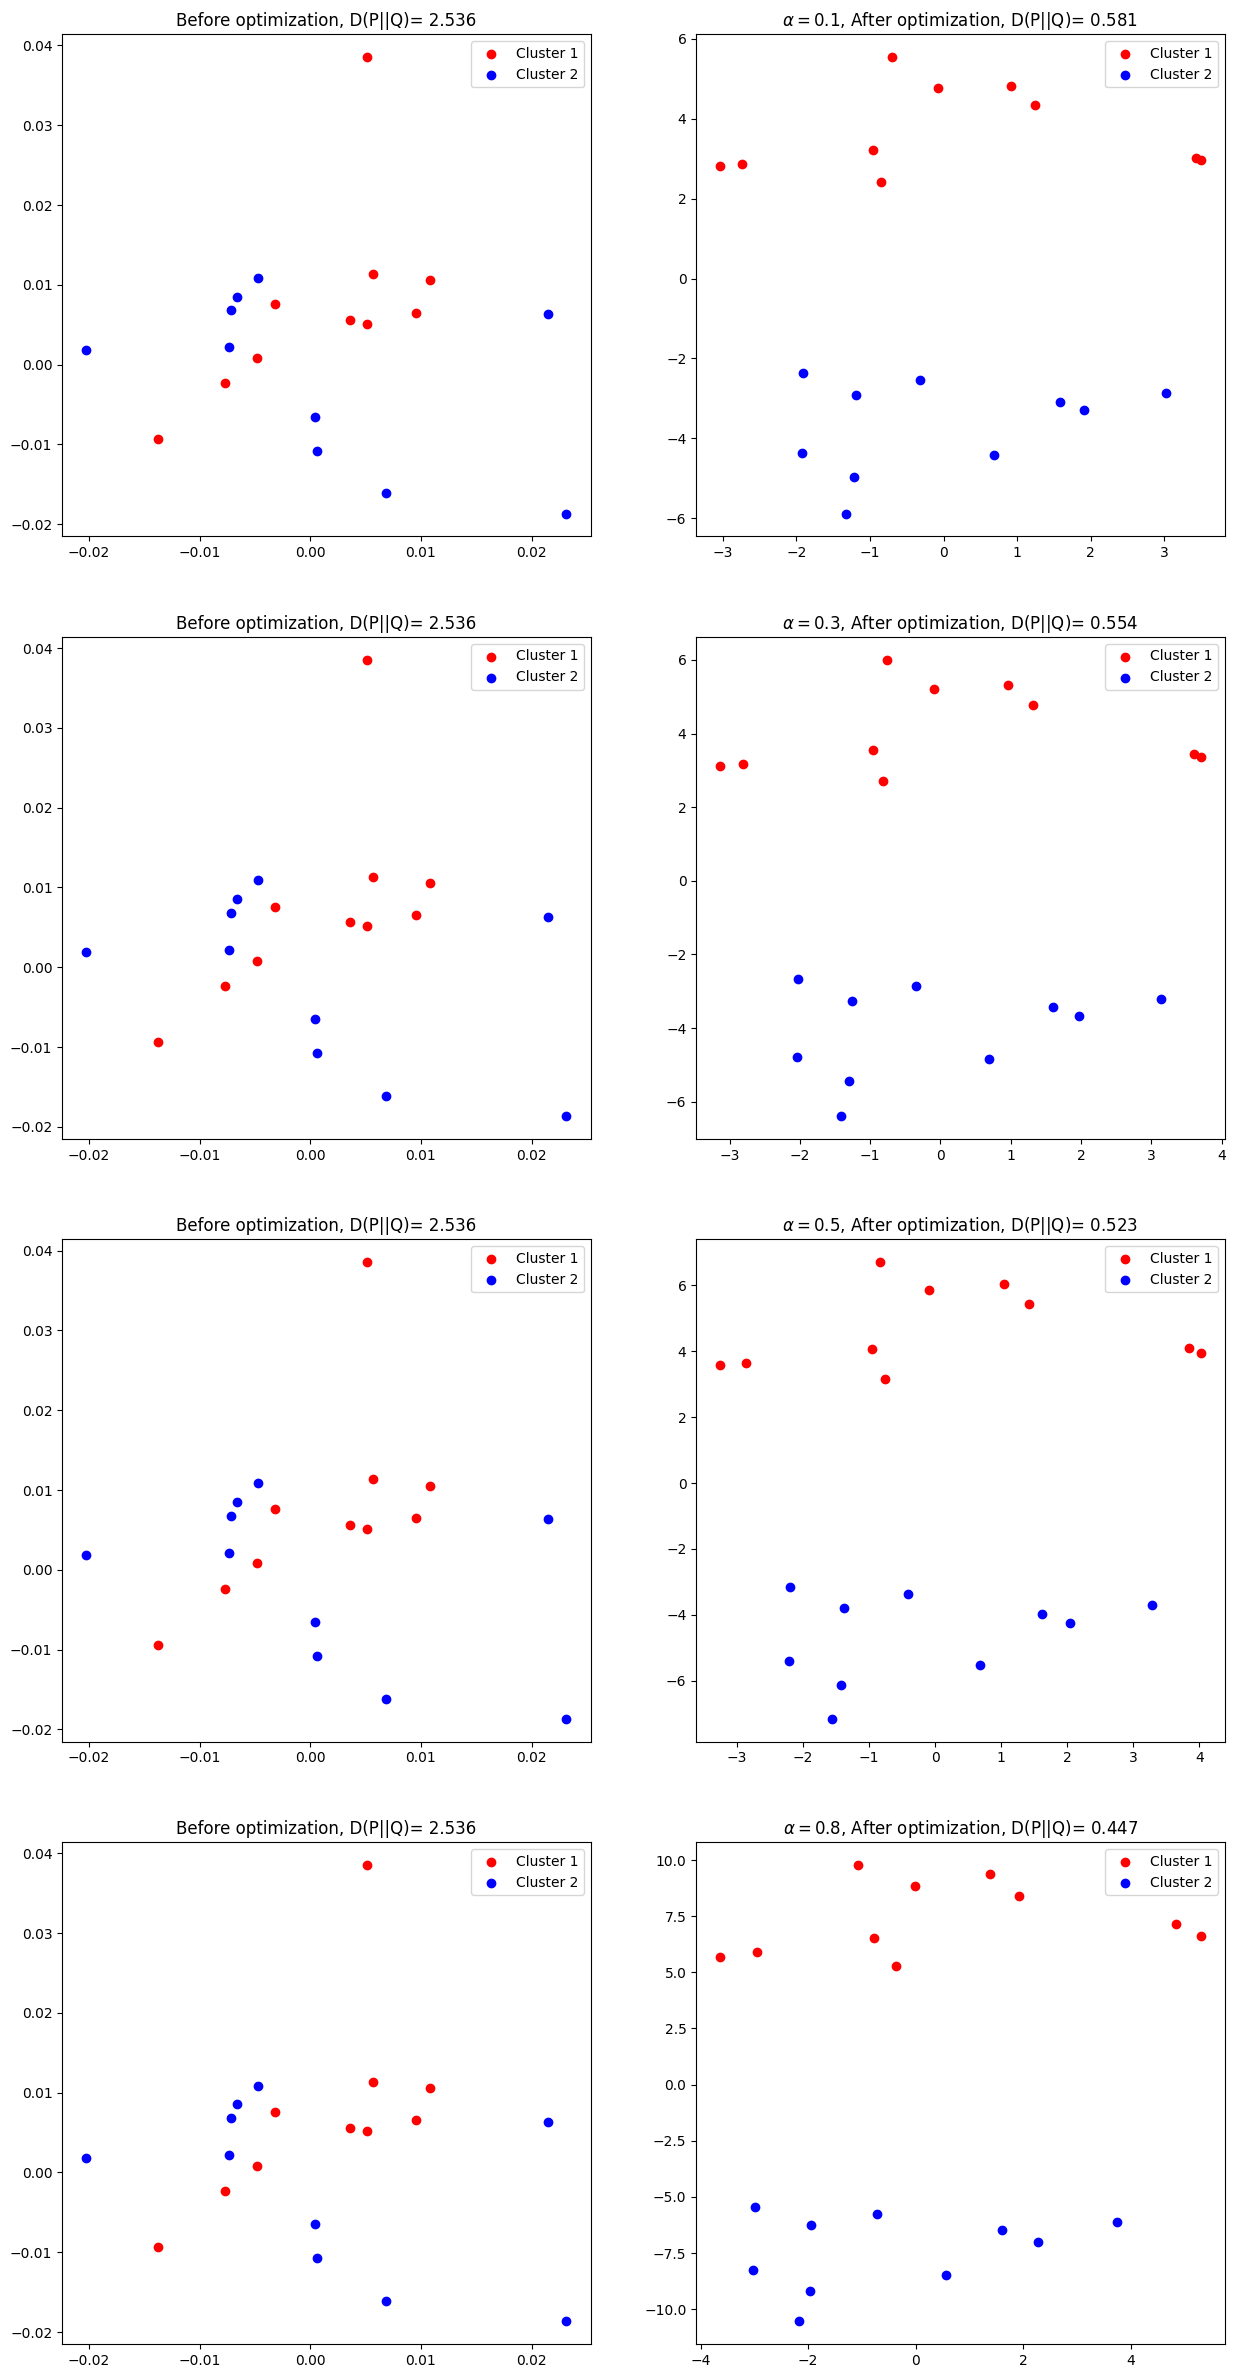

In [15]:
lr = 10.0 # Learning rate
alphas = [0.1, 0.3, 0.5, 0.8] # Momentum term
fig, ax = plt.subplots(len(alphas), 2, figsize=(15, 30))

# Plot the result of t-SNE for different values of momentum term
for i, alpha in enumerate(alphas):
    t_SNE_custom(lr, alpha, ax[i], print_alpha=True)

### (c)

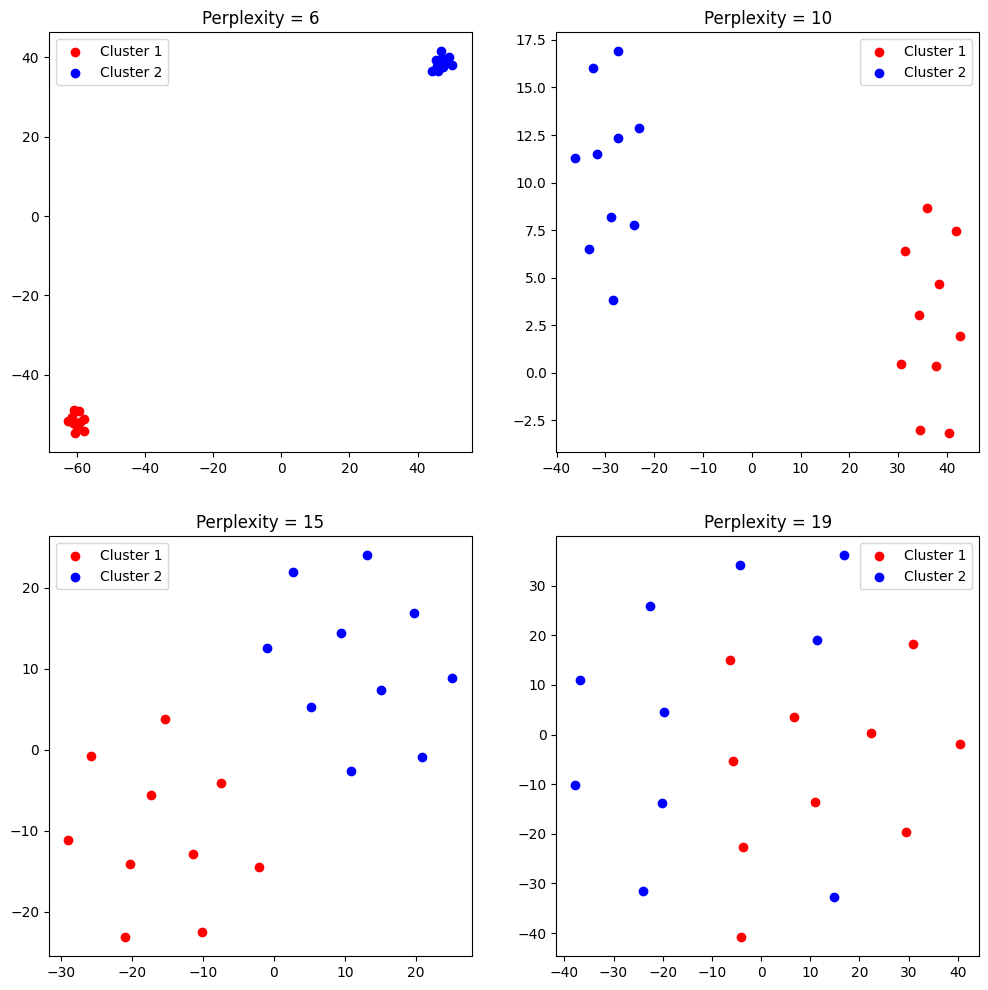

In [16]:
# Use the built-in t-SNE utility from sklearn

# Choose 4 perplexity values less than the number of points
perplexity_values = [6, 10, 15, 19]

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, perp in enumerate(perplexity_values):
    tsne = TSNE(n_components=2, perplexity=perp)
    Y_sklearn = tsne.fit_transform(X)

    hf = num_points//2
    plot_2d_embeddings(Y_sklearn, title=f"Perplexity = {perp}", ax=ax[i//2, i%2])

plt.show()